# Monte Carlo simulation Using Parallel processing

This notebook demonstrates a simple Monte Carlo simulation

In [59]:
import numpy as np
import Tkinter, tkFileDialog
import pandas as pd
import matplotlib.pyplot as plot
import sys

The following function simulates Guassian distribution of percentage changes and return cumulative percentage change

In [60]:
def change_ndays(n,avg,sd):
    """Compute percentage change for n number of days"""
    changes = np.random.normal(avg,sd,n)+1
    return np.prod(changes)

The input is a csv file. Let's use pandas to create a dataframe from the input

In [61]:
try:
    Tkinter.Tk().withdraw()
    file=tkFileDialog.askopenfile(initialfile='apple.2011.csv',title='Select File',filetypes=[('all','*'), ('csv','*.csv')])
    df=pd.read_csv(file,warn_bad_lines=True,names=['date','price','change'],skiprows=2)
except Exception, e:
    print "Error: Terminating the program! " + str(e)
    sys.exit(e)

We need mean and standard deviation for Guassian distribution

In [62]:
avg=df.change.mean()
sd=df.change.std()
print "The mean price is %s and standard deviation is %s" % (avg,sd)

The mean price is 0.000957355207171 and standard deviation is 0.0165205562984


Let's take last price we have and try to compute VaR

In [64]:
last_price=df.tail(1).iloc[0,1]
print "Last price from which VaR needs to be calculate is %s" % last_price

Last price from which VaR needs to be calculate is 405.0


Let's simulate price changes 2 million times

In [65]:
%time prices=np.array([change_ndays(20,avg,sd)*last_price for i in range(0,2000000)],dtype=float)

Wall time: 12.3 s


It took about 12 seconds in my machine to process 2 million, 20 day price calculation
Lets use parallel processing

In [66]:
from ipyparallel import Client
cl = Client()
print cl.ids
dview=cl.direct_view()
%px import numpy as np
%px def change_ndays(n,avg,sd):import numpy as np; changes = np.random.normal(avg,sd,n)+1 ;  return np.prod(changes) ;


[0, 1, 2, 3]



### Parallel Processing Method 1  
Let's compute the price changes in parallel

In [67]:
def par_price_change():
    #I was running four cluster, so let's process 500,000 per cluster 
    %px prices_p1=np.array([change_ndays(20,0.000957355207171,0.0165205562984)*405 for i in range(0,500000)],dtype=float)
    prices=dview.gather("prices_p1")
    return prices

In [68]:
cl.block=True
%time prices_par1=par_price_change()
print "Total Number of records processed:%s" % len(prices_par1)

Wall time: 4.34 s
Total Number of records processed:4


In my machine the serial processing took about 13 second while the parallel processing took about 4.3s. The parallel processing almost three times faster   

### Parallel Processing Method 2
Let's try map_sync method of direct view

In [69]:
dview = cl[:]
%time prices_par2=dview.map_sync(lambda x:change_ndays(20,0.000957355207171,0.0165205562984)*405,range(0,2000000))
print len(prices_par2)

Wall time: 7.67 s
2000000


The map_syc function took about 7.5s. That's about half of the time required to run in serial, but slower than method 1 in which we split the task equally and ran the command in the engines

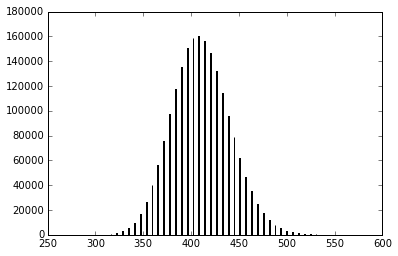

In [70]:
%matplotlib inline
histogram,bins=np.histogram(prices,bins=50)
plot.bar(bins[:-1],histogram)
plot.show()

Finally we compute VaR at 99% confidence

In [71]:
print "VaR at 99%% confidence:%s" % (np.percentile(np.sort(prices),1))

VaR at 99% confidence:346.465432474
